/home/jhk/anaconda3/envs/study/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jhk/anaconda3/envs/study/lib/python3.11/site-packages/torch/__init__.py:1145: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


[1.50059323 1.46608142 1.36747674 1.21887882 1.04157569 0.86105348
 0.70341643 0.59171984 0.54273108 0.5645736  0.65558473 0.80454778
 0.99226577 1.19425583 1.38418582 1.53757047 1.63520801 1.66587453
 1.62789777 1.52938917 1.38710172 1.22407392 1.06639078 0.93951686
 0.86471618 0.85606198 0.91845618 1.04693686 1.22737078 1.43843392
 1.65460172 1.84972917 2.00071777 2.09075453 2.11166801 2.06507047
 1.96212582 1.82197583 1.66904577 1.52960778 1.42808473 1.3836136
 1.40735108 1.50089984 1.65607643 1.85605348 2.07771569 2.29489882
 2.48205674 2.61784142 2.68809323 2.68782142 2.62189674 2.50435882
 2.35643569 2.20355348 2.07175643 1.98403984 1.95711108 1.9990336
 2.10808473 2.27298778 2.47448577 2.68803583 2.88724582 3.04757047
 3.14974801 3.18249453 3.14407777 3.04254917 2.89460172 2.72321392
 2.55441078 2.41359686 2.32197618 2.29356198 2.33319618 2.43585686
 2.58735078 2.76629392 2.94710172 3.10356917 3.21253777 3.25713453
 3.22912801 3.13007047 2.97106582 2.77119583 2.55482577 2.348167

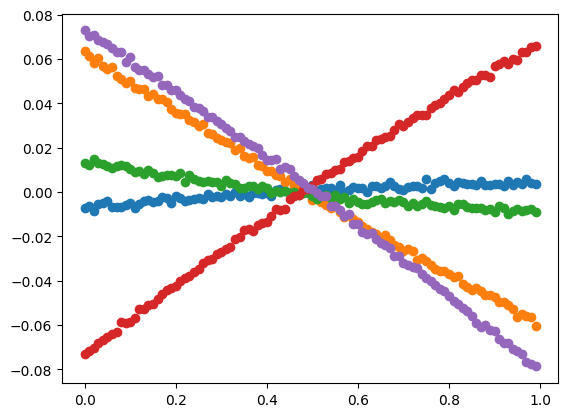

5


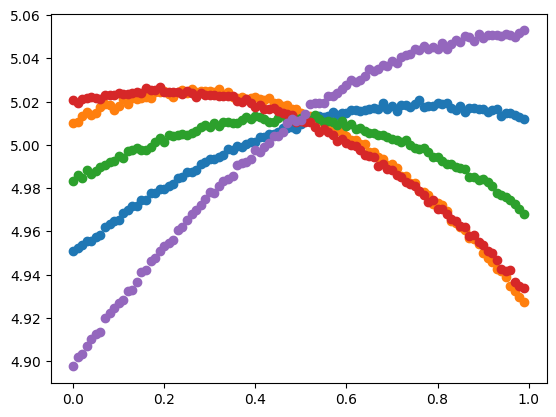

5


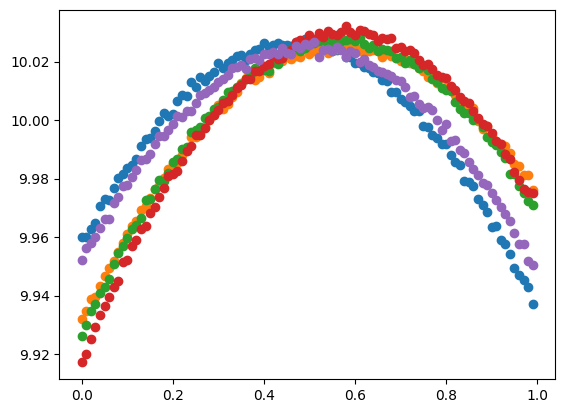

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.9.1')
#pyro.set_rng_seed(1)
torch.set_default_tensor_type(torch.DoubleTensor)

import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch

from sklearn import model_selection
import pyro.contrib.gp as gp

import torch
import numpy as np
import seaborn as sns
import arviz as az  


kernel2 = gp.kernels.RBF(input_dim=1, variance=torch.tensor(0.133), lengthscale=torch.tensor(4))


q = 2 
def func(x):
    return - np.power((np.sin(6*np.pi*x)),2) + 6*np.power(x,2) - 5*np.power(x,4) + (3/2)
x= np.linspace(0,1,100)

y = func(x)

def datafunc(x):
    return func(x) + np.random.normal(0,0.01)
    
def gendata(l):
    x = np.array(range(0,l-1))/(l-1)
    y = datafunc(x)   
    return x,y
    
data  = gendata(101)
X, y = data[0], data[1]
print(y)
#plt.scatter(X, y)
#plt.plot(x,y)
#plt.show()
print ("Area less than q", np.sum(y)/100 <q+0.01 )


w = [1/(100-1) for i in range(100)]
w[0] = 1/(200-2)
w[-1] = 1/(200-2)
w = torch.tensor(np.array(w))

#D = [(0, 1.46), (0.25, 0.93), (0.5, 2.76)]
D = np.array([(0, 1.46), (0.25, 0.93), (0.5, 2.76)])
for q in [0,5,10]:
    
    K = kernel2(torch.tensor(X), torch.tensor(X))
    S_11 = w @ K @ w
    S_21 = K @ w 
    S_12 = w @ K
    S_22 = K

    
    mean = S_21 * (1/S_11) * q
    covariance = S_22 - (S_21.unsqueeze(1) @ ((1/S_11) * S_21).unsqueeze(0)) + torch.eye(X.shape[0]) * 0.000001
    scale_tril = torch.linalg.cholesky(covariance)


    distrobution = dist.MultivariateNormal(mean, scale_tril=scale_tril)

    samples = distrobution.sample(torch.Size([5]))

    print(samples.shape[0])

    #sns.jointplot(
    #x= X,
    #y= samples[0],
    #kind="kde",
    #fill=True,
    #cmap="Blues")
    plt.scatter(X, samples[0])
    plt.scatter(X, samples[1])
    plt.scatter(X, samples[2])
    plt.scatter(X, samples[3])
    plt.scatter(X, samples[4])
    #sns.displot(samples[1], bins = 20)
    plt.show()
    



In [2]:

def posterior_prediction(X):
    # Calculate prior mean and covariance
    K = kernel2(torch.tensor(X), torch.tensor(X))
    q = 2  # Condition area under curve
    S_11 = w @ K @ w
    S_21 = K @ w 
    S_12 = w @ K
    S_22 = K

    
    jitter = 1e-6  
    mean = S_21 * (1 / (S_11 + jitter)) * q  # <-- Adjusted to include jitter
    covariance = S_22 - (S_21.unsqueeze(1) @ ((1 / (S_11)) * S_21).unsqueeze(0)) + torch.eye(X.shape[0]) * 0.0001 

    # Exclude specific indices
    excluded_indices = {0, 25, 50}
    mask = ~np.isin(np.arange(mean.shape[0]), list(excluded_indices))
    mean_original = mean[mask]
    covariance_original = covariance[mask][:, mask]

    # Compute y_to_all and y_to_y
    helper = covariance[:, list(excluded_indices)] 
    y_to_all = helper[3:, :] 
    y_to_y = helper[:3, :]  

    # Add noise to diagonal of y_to_y
    noise = torch.rand(3) * 0.01
    diagonal_tensor = torch.diag(noise)
    y_to_y_noisy = y_to_y + diagonal_tensor  

    # Posterior mean and covariance
    y_observed = torch.tensor(D[:, 1])  # Observed data
    post_mean = (
        mean_original +
        torch.tensor(y_to_all) @ (torch.linalg.inv(y_to_y_noisy)+ 0.0001) @ (y_observed - mean[list(excluded_indices)]) 
    )
    post_cov = (
        covariance_original +
        torch.tensor(y_to_all) @ (torch.linalg.inv(y_to_y_noisy) + 0.0001) @ torch.tensor(y_to_all).T 
    )
    print(covariance_original)

    print(post_mean.shape)
    print(post_cov.shape)
    return post_mean, post_cov

print(D)
post_mean, post_cov = posterior_prediction(X)

[[0.   1.46]
 [0.25 0.93]
 [0.5  2.76]]
tensor([[ 0.0020,  0.0019,  0.0019,  ..., -0.0019, -0.0019, -0.0020],
        [ 0.0019,  0.0020,  0.0018,  ..., -0.0018, -0.0019, -0.0019],
        [ 0.0019,  0.0018,  0.0019,  ..., -0.0018, -0.0018, -0.0019],
        ...,
        [-0.0019, -0.0018, -0.0018,  ...,  0.0020,  0.0019,  0.0019],
        [-0.0019, -0.0019, -0.0018,  ...,  0.0019,  0.0020,  0.0020],
        [-0.0020, -0.0019, -0.0019,  ...,  0.0019,  0.0020,  0.0021]],
       grad_fn=<IndexBackward0>)
torch.Size([97])
torch.Size([97, 97])


/tmp/ipykernel_69667/416029134.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_to_all) @ (torch.linalg.inv(y_to_y_noisy)+ 0.0001) @ (y_observed - mean[list(excluded_indices)])
/tmp/ipykernel_69667/416029134.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_to_all) @ (torch.linalg.inv(y_to_y_noisy) + 0.0001) @ torch.tensor(y_to_all).T


tensor([1.5010, 1.5120, 1.5230, 1.5340, 1.5450, 1.5560, 1.5670, 1.5779, 1.5889,
        1.5999, 1.6108, 1.6218, 1.6328, 1.6437, 1.6546, 1.6656, 1.6765, 1.6874,
        1.6983, 1.7092, 1.7201, 1.7310, 1.7039, 1.7528, 1.7639, 1.7748, 1.7856,
        1.7964, 1.8072, 1.8181, 1.8288, 1.8396, 1.8504, 1.8612, 1.8719, 1.8827,
        1.8934, 1.9041, 1.9148, 1.9255, 1.9362, 1.9469, 1.9576, 1.9682, 1.9788,
        1.9895, 2.0001, 2.0256, 2.0213, 2.0318, 2.0424, 2.0529, 2.0634, 2.0739,
        2.0844, 2.0949, 2.1053, 2.1158, 2.1262, 2.1366, 2.1470, 2.1574, 2.1678,
        2.1781, 2.1884, 2.1988, 2.2091, 2.2193, 2.2296, 2.2398, 2.2501, 2.2603,
        2.2705, 2.2807, 2.2908, 2.3010, 2.3111, 2.3212, 2.3313, 2.3413, 2.3514,
        2.3614, 2.3714, 2.3814, 2.3913, 2.4013, 2.4112, 2.4211, 2.4310, 2.4408,
        2.4507, 2.4605, 2.4703, 2.4801, 2.4898, 2.4995, 2.5092],
       grad_fn=<AddBackward0>)
[[0.   1.46]
 [0.25 0.93]
 [0.5  2.76]]
(array([], dtype=int64),)


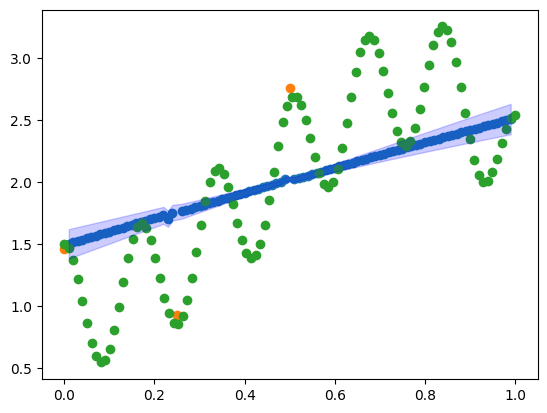

In [3]:
excluded_indices = {0, 25, 50}
mask = ~np.isin(np.arange(mean.shape[0]), list(excluded_indices))
variances = torch.diagonal(post_cov)  # Variance is on the diagonal of the covariance matrix
std_devs = torch.sqrt(variances)  
print(post_mean)
print(D)
print(np.where(variances < 0))
plt.scatter(X[mask], post_mean.detach().numpy())
plt.scatter(D[:,0], D[:, 1])
plt.scatter(x, y)
plt.fill_between(X[mask].flatten(), 
                 (post_mean - 1.96 * std_devs).detach().numpy(),  # Lower bound (95% confidence)
                 (post_mean + 1.96 * std_devs).detach().numpy(),  # Upper bound (95% confidence)
                 color='blue', alpha=0.2, label='95% Confidence Interval')


In [11]:
print ("Area less than q", np.sum(post_mean.detach().numpy())/100 <q+0.01 )

Area less than q True
